## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

In [2]:
import pyarrow as pa
from datasets import Dataset
from datasets import load_dataset
from datasets import DatasetDict

In [3]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer

In [4]:
import torch
import torch.nn.functional as F
from transformers import AutoModel

In [5]:
from sklearn.metrics import f1_score,classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score,f1_score
from transformers import Trainer
from torch.nn.functional import cross_entropy
from transformers import pipeline

C:\Users\abhij\Desktop\Transformers\transformers\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\abhij\Desktop\Transformers\transformers\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

## Helper Functions

In [6]:
def tokenize(batch):
    '''This function applies tokenizer to a batch of examples; padding=True will pad the examples with
    zeros to the size of the longest one in a batch, and truncation=True will truncate the examples
    to the model's maximum context size.'''
    return tokenizer(batch["Claim Description"],padding=True, truncation = True)

In [7]:
def filter_high_frequency_classes(data,col,pct):
    # Get value counts for each category in 'Coverage Code'
    coverage_counts =data[col].value_counts(normalize=True)*100
    
    # Filter to retain only categories with counts greater than 1 pct
    high_frequency_class = coverage_counts[coverage_counts > pct].index
    
    return high_frequency_class

In [8]:
def assign_others(cat,high_frequency_cat):
    if cat in high_frequency_cat:
        return cat
    else:
        return 'other'
        

In [9]:
def label_int2str(x,label_mapping):
    label_mapping_rev={}
    for k,v in label_mapping.items():
        label_mapping_rev[v]=k
    return label_mapping_rev[x]

In [10]:
def str2int(x,label_mapping):
    return label_mapping[x]

In [11]:
def plot_confusion_matrix(y_preds,y_true, labels=None):
    labels = y_preds.unique()
    labels.sort()
    cm = confusion_matrix(y_true, y_preds, normalize="true",labels=labels)
    fig,ax = plt.subplots(figsize=(20,6))
    disp = ConfusionMatrixDisplay(confusion_matrix =cm,display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.xticks(rotation=90)
    plt.title("Normalized Confusion Matrix")
    plt.show()

---------------

## Loading and Preparing Data

In [12]:
df = pd.read_csv(r'C:\Users\abhij\Desktop\NewGen\Gallagher\Dataset_Public.csv')
df = df[df['Claim Description'].notna()]

In [13]:
pct = 1
col = 'Coverage Code'
high_frequency_coverage_code = filter_high_frequency_classes(df,col,pct)

In [14]:
col ='Accident Source'
pct = 1
high_frequency_accident_source = filter_high_frequency_classes(df,col,pct)

In [15]:
df['Coverage Code Merged'] = df['Coverage Code'].apply(lambda x:assign_others(x,high_frequency_coverage_code))
df['Accident Source Merged'] = df['Accident Source'].apply(lambda x:assign_others(x,high_frequency_accident_source))

-----------

### Label Encoding the Merged Columns

In [16]:
# Assume `df` is your DataFrame and `categorical_column` is the column to encode
coverage_code_le = LabelEncoder()
df['Coverage Code Encoded'] = coverage_code_le.fit_transform(df['Coverage Code Merged'])

# Mapping of labels to integers
coverage_code_label_mapping = dict(zip(coverage_code_le.classes_, coverage_code_le.transform(coverage_code_le.classes_)))
print(coverage_code_label_mapping)


{'AB': 0, 'AD': 1, 'AL': 2, 'AP': 3, 'GB': 4, 'GD': 5, 'NS': 6, 'PA': 7, 'PB': 8, 'RB': 9, 'other': 10}


In [17]:
# Assume `df` is your DataFrame and `categorical_column` is the column to encode
accident_source_le = LabelEncoder()
df['Accident Source Encoded'] = accident_source_le.fit_transform(df['Accident Source Merged'])

# Mapping of labels to integers
accident_source_label_mapping = dict(zip(accident_source_le.classes_, accident_source_le.transform(accident_source_le.classes_)))
print(accident_source_label_mapping)

{'Alleged Negligent Act': 0, 'Alleged contamination or spoilage': 1, 'Alleged damage to property of others': 2, 'Alleged design flaw, defect': 3, 'Alleged foreign object in product': 4, 'Alleged improper maintenance - other': 5, 'Backed into vehicle or object': 6, 'Cart': 7, 'Ground/floor': 8, 'Human Action, NOC': 9, 'Intersection accident': 10, 'Not Otherwise Classified': 11, 'Our vehicle struck in rear': 12, 'Pothole': 13, 'Sideswipe or lane change': 14, 'Struck animal or object': 15, 'Struck parked vehicle': 16, 'Struck vehicle in rear': 17, 'Struck/pulled down wires': 18, 'Vehicle Accident': 19, 'Windshield': 20, 'e-Commerce': 21, 'other': 22}


------------

### Making the Predictions

In [18]:
def return_predictions(x,label_mapping):
    x = int(x['label'].split('_')[-1])
    return label_int2str(x,label_mapping)

In [19]:
## task =1 for `Coverage Code` predictions
## task =2 for `Accident Source` predictions

task=1

if task==1:
    model_path = r'C:\Users\abhij\Desktop\Transformers\transformers\Notebooks\Gallhagher_AJG\results\model1'
    input_col = 'Claim Description'
    target_col = 'Coverage Code Merged'
    labels = coverage_code_label_mapping
    model_id = "abhxaxhbshxahxn/CoverageCodePred"
else:
    model_path = r'C:\Users\abhij\Desktop\Transformers\transformers\Notebooks\Gallhagher_AJG\results_accident_source\model1'
    input_col = 'Claim Description'
    target_col = 'Accident Source Merged'
    labels = accident_source_label_mapping
    model_id = "abhxaxhbshxahxn/AccidentSource_Predictions"

In [22]:
save_path = model_path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)
# model = AutoModelForSequenceClassification.from_pretrained(save_path, return_dict=True).to(device)
# tokenizer = AutoTokenizer.from_pretrained(save_path)

Device: cuda


In [32]:
classifier_ = pipeline("text-classification",model= model_id,device=device)

In [33]:
# classifier_ = pipeline("text-classification",model= model,tokenizer= tokenizer,device=device)

#### Prediction on a single input

In [34]:
# labels = accident_source_label_mapping.keys()
# custom_tweet = [desc for desc in df.loc[2,'Claim Description']]
idx = 10000
custom_input = df.loc[idx,input_col]
correct = df.loc[idx,target_col]
preds = classifier_(custom_input, return_all_scores=True)
pred_df = pd.DataFrame(preds[0])

C:\Users\abhij\Desktop\Transformers\transformers\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


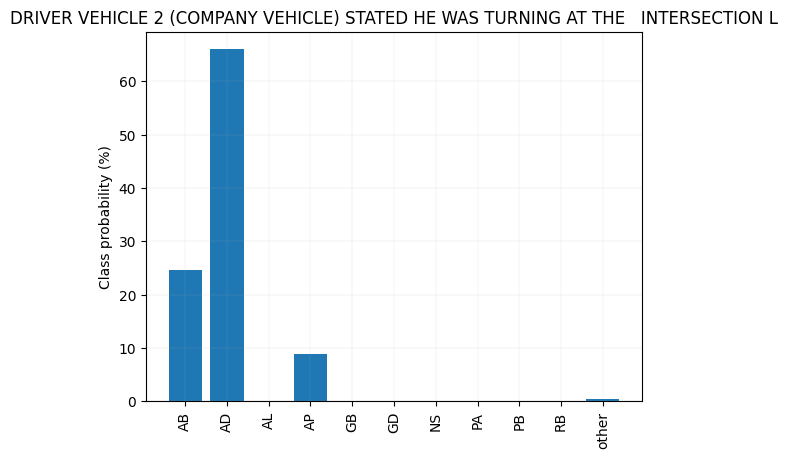

In [35]:
plt.bar(labels.keys(),100*pred_df["score"],color='C0')
if len(custom_input)>80:
    plt.title(f"{custom_input[:80]}")
else:
    plt.title(f"{custom_input}")
plt.ylabel("Class probability (%)")
plt.grid(True,linewidth=0.1)
plt.xticks(rotation=90)
plt.show()

In [36]:
print("Actual Label is:",correct)

Actual Label is: AD


#### Prediction on a multiple outputs

In [216]:
custom_input = [df.loc[idx,input_col] for idx in df.index]
correct = [df.loc[idx,target_col] for idx in df.index]
preds = classifier_(custom_input[:50], top_k=1)
pred_df = pd.DataFrame(preds)

In [217]:
pred_df['Claim Description'] = custom_input[:50]
pred_df['Predictions'] = pred_df[0].apply(lambda x:return_predictions(x,label_mapping=labels))
pred_df['Confidence'] = pred_df[0].apply(lambda x:x['score'])
pred_df['Actual'] = correct[:50]
pred_df.drop(0,axis=1,inplace=True)

In [218]:
pred_df.head()

,Claim Description,Predictions,Confidence,Actual
0,THE IV WAS MAKING A LEFT TURN ON A GREEN ARROW...,AB,0.684040,other
1,CLAIMANT ALLEGES SHE SUFFERED INJURIES IN AN E...,GB,0.909479,GB
2,"IV PASSENGER SUSTAINED INJURIES, OV AND IV COL...",AB,0.456389,AB
3,CLAIMANT ALLEGES SHE WAS BURNED UNKNOWN DEGREE...,PA,0.987660,PA
4,THE IV WAS MERGING INTO A CONSTRUCTION ZONE WH...,AD,0.837581,AD


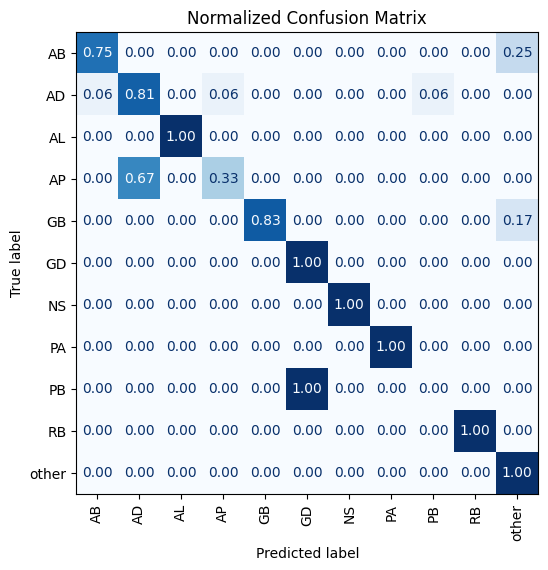

In [219]:
plot_confusion_matrix(pred_df['Actual'], pred_df['Predictions'])

In [80]:
# pred_df.to_csv('Predictions.csv')

---------------